**Make a simple model of learned PWMs**

The model predicts log(K27act counts +1) from ATAC at sequence resolution and sequence

In [3]:
# load in relevant packages
import change_path
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'


import tf_memory_limit
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sequence
import ucscgenome
from tqdm import tqdm
import time
import datagen
import sequence
import helper
import viz_sequence
import pickle
from keras.models import Model, load_model
from keras.layers import Input, Dense, SpatialDropout1D, Conv1D, Lambda, Dropout, Activation, Concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
from colour import Color
from livelossplot import PlotLossesKeras
import lasso
import training_tools
import shutil

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

['', '/usr/lib/python35.zip', '/usr/lib/python3.5', '/usr/lib/python3.5/plat-x86_64-linux-gnu', '/usr/lib/python3.5/lib-dynload', '/home/kal/VENV/lib/python3.5/site-packages/', '/home/kal/VENV/lib64/python3.5/site-packages/', '/home/kal/VENV/lib/python3.5/site-packages/IPython/extensions/', '/home/kal/K27act_models/bin/', '/home/kal/TF_models/bin/', '/home/kal/.ipython']


Using TensorFlow backend.
/home/kal/TF_models/bin/sequence.py:275: RuntimeWarning: divide by zero encountered in log
  self.seq = helper.softmax(np.log(dist))


160363 training samples
3413 testing samples
3414 validation samples


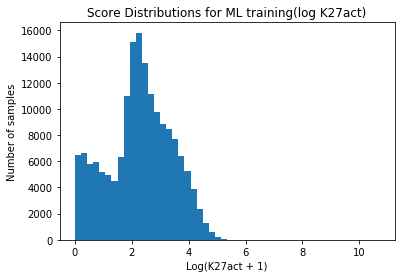

In [4]:
# load in data

#load in the DNA
genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')

# load in ATAC data
atac_path = '/home/kal/K27act_models/GM_data/ATAC/atac_average.hdf5'
atac = h5py.File(atac_path, 'r')

# load in preprocessed data
peaks_path = '/home/kal/K27act_models/GM_data/k27act_training_regions.bed'
peaks = pd.read_table(peaks_path, header=None)
#note we make the 'k27act' column the 'score' column for the correct training behavior
peaks.columns='chr start end name fold_change atac k27act nucs'.split() 
peaks['score'] = np.log(peaks['k27act'] + 1)

# facts about the data
num_training_samples = len(peaks[(peaks.chr != 'chr8')])
print('{} training samples'.format(num_training_samples))
num_testing_samples = len(peaks[(peaks.chr == 'chr8') & (peaks.index%2 == 0)])
print('{} testing samples'.format(num_testing_samples))
num_validaiton_samples = len(peaks[(peaks.chr == 'chr8') & (peaks.index%2 == 1)])
print('{} validation samples'.format(num_validaiton_samples))

# make a histogram of score
plt.hist(peaks['score'], bins=50)
plt.title('Score Distributions for ML training(log K27act)')
plt.ylabel('Number of samples')
plt.xlabel('Log(K27act + 1)')
plt.show()

In [5]:
def make_pwm_model(get_grads=False, atac_only=False, seq_only=False, batch_size=32):
    # model's input
    if atac_only:
         seqs = Input(batch_shape=(batch_size, 1024, 1), name='input_seqs')
    elif seq_only:
        seqs = Input(batch_shape=(batch_size, 1024, 4), name='input_seqs')
    else:
        seqs = Input(batch_shape=(batch_size, 1024, 5), name='input_seqs')
    num_outputs=1

    #build custom functions
    def add_RC(x):
        if atac_only:
            RC = x[:, ::-1, ::-1]
        elif seq_only:
             RC = x[:, ::-1, ::-1]
        else:
            RC = K.concatenate([x[:, ::-1, :1], x[:, ::-1, 1:][::-1]], axis=2)
        return K.concatenate([x, RC], axis=0)
    def add_RC_shape(s):
        return 2*s[0], s[1], s[2]

    # add the rc, do a convolution w/o activation and combine down then take concat activation across forward and reverse
    add_rc = Lambda(add_RC, name='add_rc', output_shape=add_RC_shape)
    conv = Conv1D(256, 16, name='conv_in', padding='same', activation=None)(add_rc(seqs))
    conv_dropped = SpatialDropout1D(0.1)(conv)
    combined = Dense(64, activation='relu')(conv_dropped)
    fr_conv = Lambda(lambda x: K.concatenate([x[:x.shape[0]//2, :, :], x[x.shape[0]//2:, ::-1, :]], axis=2), 
                       name='stack_fr', output_shape=lambda s: (s[0] // 2, s[1], s[2] * 2))(combined)

    # then use a dense to get one 'k27ness' per input base
    per_base = Dense(num_outputs)(fr_conv)
    # sum the k27ness and take the max of forward or reverse
    predictions = Lambda(lambda x: K.sum(x, axis=1), name='sum_seq', 
                     output_shape=lambda s: (s[0], 1))(per_base)

    # build the model
    model = Model(inputs=seqs, outputs=predictions)
    model.summary()
    if get_grads:
        grads = K.gradients(predictions, seqs)[0]
        return model, grads
    return model

In [11]:
def train_model(out_dir, model_string, vpe=5, opt=Adam(lr=0), num_epochs=3, batch_size=32, 
                lr_sched=([0, 5, 10], [1e-04, 1e-05, 1e-06]), use_lasso=False, atac_only=False, seq_only=False):
    
    # directory creation
    temp_path = os.path.join(out_dir, 'model_in_training')
    try:
        os.makedirs(temp_path)
    except FileExistsError as e:
        print('Warning, overwriting current model in training')
        shutil.rmtree(temp_path)
        os.makedirs(temp_path)
    # make a file system
    weights_path = os.path.join(temp_path, 'intermediate_weights')
    os.makedirs(weights_path)
    history_path = os.path.join(temp_path, 'history')
    os.makedirs(history_path)
    
    # get the model
    if use_lasso:
        model, grads = make_pwm_model(get_grads=True, atac_only=atac_only, seq_only=seq_only, batch_size=batch_size)
    else:
        model = make_pwm_model(atac_only=atac_only, seq_only=seq_only, batch_size=batch_size)
        
    # compile model
    if use_lasso:
        model.compile(loss=lasso.get_lwg(grads), metrics=['mean_absolute_error', lasso.get_gp(grads)], optimizer=opt)
    else:
        model.compile(loss='mean_absolute_error', metrics=['mean_absolute_error'], optimizer=opt)
    early_stop = EarlyStopping(monitor='val_loss', patience=2*vpe)
    filepath = os.path.join(weights_path, 'weights-{epoch:02d}-{val_loss:.3f}.hdf5')
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    # training params
    train_gen = datagen.batch_gen(peaks, mode='train', atac_only=atac_only, seq_only=seq_only, batch_size=batch_size)
    val_gen = datagen.batch_gen(peaks, mode='val', atac_only=atac_only, seq_only=seq_only, batch_size=batch_size)
    spe = num_training_samples//(batch_size*vpe)
    spve = num_validaiton_samples//(batch_size*(vpe//5))
    callbacks=[early_stop, checkpoint, PlotLossesKeras(), training_tools.ChangeLR(lr_sched[0], lr_sched[1])]
    
    # train the model
    losses = model.fit_generator(train_gen, steps_per_epoch=spe, epochs=num_epochs*vpe, 
                                 callbacks=callbacks, validation_data=val_gen, validation_steps=spve, verbose=2)

    # final save
    model.save(os.path.join(temp_path, 'final_model.h5'))
    val_hist = losses.history['val_loss']
    train_hist = losses.history['loss']
    losses=dict()
    losses['val_loss'] = val_hist
    losses['loss'] = train_hist
    pickle.dump(losses, open(os.path.join(history_path, 'history.pk'), 'wb'))    
        
    # final directory change
    timestr = time.strftime('%Y%m%d_%H%M%S')
    out_path = os.path.join(out_dir, timestr + '_' + model_string)
    os.rename(temp_path, out_path)
    print('Model moved to ' + out_path)

We want a series of similar models to compare:
- with lasso
- without lasso

As well as:
- only sequence
- only atac
- both

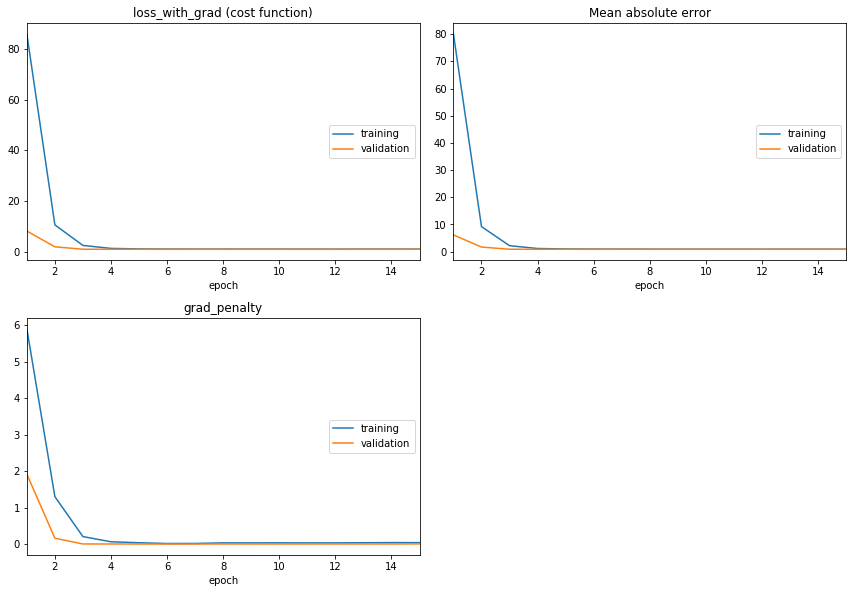

Model moved to /home/kal/K27act_models/pwm_models/20180801_125028_lasso_loss


In [12]:
out_dir = '/home/kal/K27act_models/pwm_models/'

# full series of models to test

train_model(out_dir, 'mae_loss')
train_model(out_dir, 'lasso_loss', use_lasso=True)

In [9]:
pickle.dump(losses, open(os.path.join(history_path, 'history.pk'), 'wb'))    
        


NameError: name 'losses' is not defined

In [ ]:
    # final directory change
    timestr = time.strftime('%Y%m%d_%H%M%S')
    out_path = os.path.join(out_dir, timestr + '_' + model_string)
    os.rename(temp_path, out_path)
    print('Model moved to ' + out_path)